# Case study demonstrating the Energy Resilience and Performance tool

## Initialization

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import copy
import os
from src.post_and_poll import get_api_results
API_KEY = '30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3'  # REPLACE WITH YOUR API KEY
#root_url = "https://developer.nrel.gov/api/reopt/stable"
# root_url = "http://host.docker.internal:8000/dev"
root_url = "http://0.0.0.0:8000/dev"
reopt_results_url = root_url + '/job/{run_uuid}/results/?api_key=' + API_KEY
erp_url = root_url + '/erp/' 
erp_results_url = erp_url + '{run_uuid}/results/?api_key=' + API_KEY



In [2]:
# the following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

In [3]:
"""
Here are some convenience definitions for using the Multi-scenario capabilities
"""
##############################################################################################################
inputs_path = os.path.join(".", 'inputs')
outputs_path = os.path.join(".", 'outputs')
loads_path = os.path.join(".", 'load_profiles')
rates_path = os.path.join(".", 'electric_rates')
##############################################################################################################

## Helper functions

In [4]:
def summarize_reopt_results(reopt_post, reopt_response):
    print("NPV ($) = ", reopt_response["outputs"]["Financial"]["npv"])
    print("Capital Cost, Net ($) = ", reopt_response["outputs"]["Financial"]["lifecycle_capital_costs"])
    tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage", "ColdThermalStorage", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine"]
    for tech in tech_list:
        if tech in reopt_post.keys():# and post_1[tech]["max_kw"]>0.0:
            if tech == "GHP":
                print("GHX Number of Boreholes = ", reopt_response["outputs"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
                print("GHP Heat Pump Capacity (ton) = ", reopt_response["outputs"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
            # PV and Storage are considered if the POST does not explicitly make max_[size] == 0
            for size_name_value in [(key, val) for key, val in reopt_response["outputs"][tech].items() if "size" in key]:
                    print(tech + " " + size_name_value[0], " = ", size_name_value[1])
        elif tech in ["PV", "ElectricStorage"]:# and (post_1[tech]["max_kw"]>0.0):
            for size_name_value in [(key, val) for key, val in reopt_response["outputs"][tech].items() if "size" in key]:
                    print(tech + " " + size_name_value[0], " = ", size_name_value[1])

## Load a previously saved API response .json file instead of running REopt

In [ ]:
response_json = 'results'
with open(os.path.join(outputs_path, response_json + '.json'), 'rb') as handle:
    api_response = json.load(handle)

## REopt Inputs

In [5]:
# Peak load occurs on 9/28
# Model 96 hour outage during 9/26-29
outage_start = 269*24+1
outage_end = outage_start+96-1 #inclusive

reopt_post_initial = {
    "Site": {
        #San Fransisco
        "latitude": 37.77,
        "longitude": -122.42
    },
    "ElectricLoad": {
        "doe_reference_name": "Hospital",
        "annual_kwh": 7752817.0*1.4, #makes peak load ~2MW
        "critical_load_percent": 0.5
    },  
    "ElectricTariff": {
        "urdb_label": "62d5b7fc4939f52c862151f9"
    },
    "ElectricUtility": {
        "outage_start_time_step": outage_start,
        "outage_end_time_step": outage_end
    },
    "Generator": {
        "max_kw": 1e7,
        "fuel_avail_gal": 1e9
    },  
    "PV": {
        "max_kw": 1e7
    },    
    "ElectricStorage": {
        "max_kwh": 1e7,
        "max_kw": 1e7
    }    
}

### Load in a custom electric rate generated from https://reopt.nrel.gov/tool/custom_tariffs

In [ ]:
load_electric_rate = "PGE_E20"
with open(os.path.join(rates_path, load_electric_rate + ".json"), 'r') as fp:
    rate_1 = json.load(fp)
post_1["Scenario"]["Site"]["ElectricTariff"]["urdb_response"] = rate_1

## Save the POST to a .json file for sharing or future loading in

In [ ]:
# Convert python dictionary post into json and save to a .json file
post_save = post_1
post_name = "post_1"
with open(os.path.join(inputs_path, post_name + ".json"), 'w') as fp:
    json.dump(post_save, fp)

## Or load in a saved .json file for the inputs/POST

In [ ]:
# Load a json into a python dictionary
load_post = "dev_web_sample_site_resilience_with_generator_inputs"
with open(os.path.join(inputs_path, load_post + ".json"), 'r') as fp:
    post_1 = json.load(fp)

## POST inputs and GET results from the REopt API

### Note, the `api_url` in the `get_api_results` function below calls the **production server** hosted API (master/main branch/version, publicly accessible)

#### For calling a locally-hosted (localhost) API, see:
- https://github.com/NREL/REopt_Lite_API/wiki/localhost-URLs-for-calling-locally-hosted-API

#### For calling an API hosted on an NREL-internal server (only NREL users can access this), see:
- https://github.nrel.gov/REopt/API_scripts/wiki/API-URLs-for-NREL-internal-servers

`get_api_results` POST's your inputs to the API `job` endpoint, which provides a `run_uuid` if the input is valid, and then polls the `results` endpoint using the `run_uuid` until the results come back with a status other than `Optimizing...`.

`get_api_results` also saves the results (full API response, including inputs) to the `results_file`.

A log file is also created in the current working directory.

In [19]:
reopt_initial_outputs_file_name = "erp_tag3_reopt_results_inital"
reopt_initial_outputs = get_api_results(post=reopt_post_initial, 
                               API_KEY=API_KEY, 
                               api_url=root_url, 
                               results_file=os.path.join(
                                   outputs_path, 
                                   reopt_initial_outputs_file_name+".json"
                               ), 
                               run_id=None)

main         INFO     Response OK from http://0.0.0.0:8000/dev/job/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling http://0.0.0.0:8000/dev/job/bef3f366-af94-4a08-9804-fa07b65f3011/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag3_reopt_results_inital.json


### If you get disconnected from the polling function but you think it ran, copy the run_uuid from the log above to manually GET the results:

In [ ]:
run_uuid = ""
resp = requests.get(url=reopt_results_url.format(run_uuid=run_uuid), verify=False)
reopt_initial_outputs = json.loads(resp.text)

## Summarize inital REopt optimization results

In [24]:
with open(os.path.join(outputs_path, reopt_initial_outputs_file_name + '.json'), 'rb') as handle:
    reopt_initial_outputs = json.load(handle)
    summarize_reopt_results(reopt_post_initial, reopt_initial_outputs)

NPV ($) =  4141327.99
Capital Cost, Net ($) =  6312017.6807
PV size_kw  =  4134.5846
ElectricStorage size_kw  =  782.64
ElectricStorage size_kwh  =  4897.09
Generator size_kw  =  340.94


In [ ]:
pv_total_kw_series = [api_response["outputs"]["PV"]["year_one_to_load_series_kw"][i] + 
                    api_response["outputs"]["PV"]["year_one_to_battery_series_kw"][i] + 
                    api_response["outputs"]["PV"]["year_one_to_grid_series_kw"][i] + 
                    api_response["outputs"]["PV"]["year_one_curtailed_production_series_kw"][i] for i in range(len(api_response["outputs"]["PV"]["year_one_to_load_series_kw"]))]
pv_production_factor = [prod_kw / api_response["outputs"]["PV"]["size_kw"] for prod_kw in pv_total_kw_series]



In [6]:
reopt_post_rounded = reopt_post_initial
rounded_gen_size = 350
reopt_post_rounded["Generator"]["max_kw"] = rounded_gen_size
reopt_post_rounded["Generator"]["min_kw"] = rounded_gen_size

reopt_rounded_outputs_file_name = "erp_tag3_reopt_results_rounded"
reopt_rounded_outputs = get_api_results(post=reopt_post_rounded, 
                               API_KEY=API_KEY, 
                               api_url=root_url, 
                               results_file=os.path.join(
                                   outputs_path, 
                                   reopt_rounded_outputs_file_name+".json"
                               ), 
                               run_id=None)

main         INFO     Response OK from http://0.0.0.0:8000/dev/job/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling http://0.0.0.0:8000/dev/job/837cc9bd-136f-4d2d-bb2d-7c0ee966c628/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag3_reopt_results_rounded.json


In [7]:
with open(os.path.join(outputs_path, reopt_rounded_outputs_file_name + '.json'), 'rb') as handle:
    reopt_rounded_outputs = json.load(handle)
    summarize_reopt_results(reopt_post_rounded, reopt_rounded_outputs)

NPV ($) =  4139042.24
Capital Cost, Net ($) =  6170641.8836
PV size_kw  =  4071.6388
ElectricStorage size_kw  =  773.3
ElectricStorage size_kwh  =  4681.54
Generator size_kw  =  350.0


### Run the ERP tool with REopt results and inputs

In [ ]:
0 or 500

In [8]:
post_erp_all_techs = {
        "reopt_run_uuid": reopt_rounded_outputs["run_uuid"],
        "generator_operational_availability": 0.9998, 
        "generator_failure_to_start" : 0.0066, 
        "generator_failure_to_run" : 0.00157,
        "num_generators" : 1,
        "num_battery_bins" : 101,
        "max_outage_duration" : reopt_post_rounded["ElectricUtility"]["outage_end_time_step"] - reopt_post_rounded["ElectricUtility"]["outage_start_time_step"] + 1,
    
}
post_erp_gen_only = post_erp_all_techs.copy()
post_erp_gen_only.update({
        "num_generators": 3,
        "generator_size_kw" : 500,
        "battery_size_kw" : 0,
        "battery_size_kwh" : 0,
        "pv_size_kw" : 0
    }
)

In [ ]:
# Load a json into a python dictionary
#load_post = "ERP_only_sim_post"
load_post = "ERP_REopt_sim_post"
with open(os.path.join(inputs_path, load_post + ".json"), 'r') as fp:
    post_erp = json.load(fp)
post_erp["reopt_run_uuid"] = api_response["run_uuid"]

In [9]:
erp_all_techs_outputs_file_name = "erp_tag3_erp_results_all_techs"
erp_all_techs_outputs = get_api_results(post=post_erp_all_techs, 
                                API_KEY=API_KEY, 
                                api_url=root_url, 
                                results_file=os.path.join(
                                   outputs_path, 
                                   erp_all_techs_outputs_file_name+".json"
                                ), 
                                run_id=None,
                                ERP=True)

main         INFO     Response OK from http://0.0.0.0:8000/dev/erp/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling http://0.0.0.0:8000/dev/erp/05e4530f-dcdd-4c02-969e-da87872e24df/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag3_erp_results_all_techs.json


In [11]:
erp_gen_only_outputs_file_name = "erp_tag3_erp_results_gen_only"
erp_gen_only_outputs = get_api_results(post=post_erp_gen_only, 
                                API_KEY=API_KEY, 
                                api_url=root_url, 
                                results_file=os.path.join(
                                   outputs_path, 
                                   erp_gen_only_outputs_file_name+".json"
                                ), 
                                run_id=None,
                                ERP=True)

main         INFO     Response OK from http://0.0.0.0:8000/dev/erp/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3.
main         INFO     Polling http://0.0.0.0:8000/dev/erp/668bb58a-5899-40c0-99f2-f65f7fa40c50/results/?api_key=30eStqyC1wlaSn5q89nYi4PkNQ6h1veqInY8xJR3 for results with interval of 5s...
main         INFO     Saved results to ./outputs/erp_tag3_erp_results_gen_only.json


#### POST to the ERP tool to run

In [52]:
erp_post_resp_all_techs = requests.post(url=erp_url, json=post_erp_all_techs, verify=False)
erp_post_resp_gen_only = requests.post(url=erp_url, json=post_erp_gen_only, verify=False)

#### GET the ERP results

In [61]:
erp_uuid_all_techs = json.loads(erp_post_resp_all_techs.text)["run_uuid"]
erp_all_techs_outputs = json.loads(requests.get(url=erp_results_url.format(run_uuid=erp_uuid_all_techs), verify=False).text)
erp_all_techs_outputs.get('Error',"Success")

'Success'

In [60]:
erp_uuid_gen_only = json.loads(erp_post_resp_gen_only.text)["run_uuid"]
erp_gen_only_outputs = json.loads(requests.get(url=erp_results_url.format(run_uuid=erp_uuid_gen_only), verify=False).text)
erp_gen_only_outputs.get('Error',"Success")

'Success'

#### ERP Plots

In [ ]:
erp_response.keys()

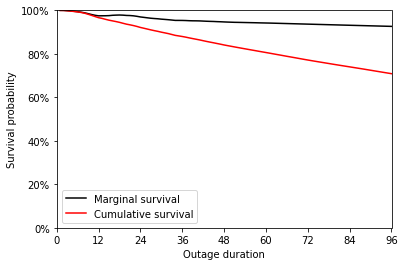

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
cum_survival = erp_all_techs_outputs["outputs"]["mean_cumulative_survival_by_duration"]
mar_survival = erp_all_techs_outputs["outputs"]["mean_marginal_survival_by_duration"]
max_duration = len(cum_survival)
outage_durations = range(1, max_duration + 1)

#Creates line plots. As set up is plotting marginal and cumulative survival on same plot. 
plt.plot(outage_durations, mar_survival, linestyle='-', label = "Marginal survival", color = "black")
plt.plot(outage_durations, cum_survival, linestyle='-', label = "Cumulative survival", color = "red")
plt.xlabel("Outage duration")
plt.ylabel("Survival probability")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylim([0,1])
plt.xlim([1,max_duration])
time_list =   [120, 48, 24,  12, 8]
time_ticks = [12,   6,  3,   2, 1]

tick_mark_step = 24
for i in range(len(time_list)):
    if max_duration < time_list[i]:
        tick_mark_step = time_ticks[i]

plt.xticks(range(0, max_duration+1, tick_mark_step))
plt.legend()
plt.show()

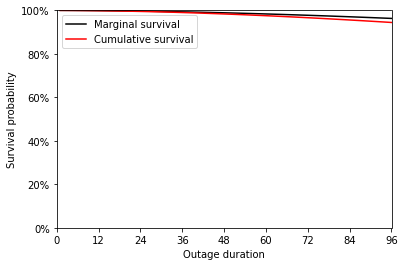

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
cum_survival = erp_gen_only_outputs["outputs"]["mean_cumulative_survival_by_duration"]
mar_survival = erp_gen_only_outputs["outputs"]["mean_marginal_survival_by_duration"]
max_duration = len(cum_survival)
outage_durations = range(1, max_duration + 1)

#Creates line plots. As set up is plotting marginal and cumulative survival on same plot. 
plt.plot(outage_durations, mar_survival, linestyle='-', label = "Marginal survival", color = "black")
plt.plot(outage_durations, cum_survival, linestyle='-', label = "Cumulative survival", color = "red")
plt.xlabel("Outage duration")
plt.ylabel("Survival probability")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylim([0,1])
plt.xlim([1,max_duration])
time_list =   [120, 48, 24,  12, 8]
time_ticks = [12,   6,  3,   2, 1]

tick_mark_step = 24
for i in range(len(time_list)):
    if max_duration < time_list[i]:
        tick_mark_step = time_ticks[i]

plt.xticks(range(0, max_duration+1, tick_mark_step))
plt.legend()
plt.show()

## Save API response into a JSON file for later use

In [63]:
response_save = erp_all_techs_outputs
file_name_to_save = "erp_tag3_erp_results_all_techs"
with open(os.path.join(outputs_path, file_name_to_save + ".json"), 'w') as fp:
    json.dump(response_save, fp)

In [65]:
response_save = erp_gen_only_outputs
file_name_to_save = "erp_tag3_erp_results_gen_only"
with open(os.path.join(outputs_path, file_name_to_save + ".json"), 'w') as fp:
    json.dump(response_save, fp)